#1. Model

In [19]:
from re import X
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    """
    DLinear
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            self.Linear_Decoder = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Decoder.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Decoder = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

#2. Đọc dữ liệu

In [20]:
import pandas as pd
import torch
from datetime import datetime, timedelta
# 2. Đọc file
df = pd.read_excel('bnb_processed_data.xlsx')
# df1=df.reset_index()['Close'] bỏ

In [21]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
1,2019-03-02,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2,2019-03-03,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
3,2019-03-04,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
4,2019-03-05,11.520388,13.841443,11.520388,13.811967,13.811967,237026335
...,...,...,...,...,...,...,...
1914,2024-05-27,599.825928,613.388184,599.700745,603.526428,603.526428,1691663828
1915,2024-05-28,603.526428,604.985107,593.716187,601.213257,601.213257,1852329404
1916,2024-05-29,601.213257,602.931519,592.966614,594.972046,594.972046,1642696946
1917,2024-05-30,594.972534,601.665039,586.557678,595.026794,595.026794,1737524745


In [22]:
# Chuyển dữ liệu thời gian
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

#3. Chia tỉ lệ 7:2:1

In [23]:
# Chia tỉ lệ
# Lấy dữ liệu cần phân tích
time_series_Close = df['Close']


# numeric_columns = ['Close', 'Open', 'High', 'Low']
numeric_columns = ['Close']

# Chuyển các giá trị số thành tensor
numeric_data = df[numeric_columns].values.astype(np.float32)

# Mở rộng chiều để phù hợp với đầu vào của mô hình
numeric_data = np.expand_dims(numeric_data, axis=0)

# Tỉ lệ 7:2:1
# Kích thước tập dữ liệu (7:2:1)
train_size= int(0.7 * len(time_series_Close))
test_size = int(0.2 * len(time_series_Close))
val_size= int(len(time_series_Close) - train_size - test_size)
# Giá trị tập từ liệu (7:2:1)
train_data = time_series_Close[:train_size]
test_data = time_series_Close[train_size:train_size + test_size]
val_data = time_series_Close[-val_size:]
# Giá trị tensor
input_data_train = torch.tensor(numeric_data[:, :train_size, :])
input_data_test = torch.tensor(numeric_data[:, train_size:train_size + test_size,:])
input_data_val = torch.tensor(numeric_data[:,-val_size:,])

# BỔ SUNG
# Lấy dữ liệu 100 ngày gần nhất
recent_100_Close = time_series_Close[-100:]
# Chuyển đổi dữ liệu 100 ngày gần nhất thành numpy array và mở rộng chiều
recent_100_Close_array = recent_100_Close.values.astype(np.float32)
recent_100_Close_array = np.expand_dims(recent_100_Close_array, axis=0)
recent_100_Close_array = np.expand_dims(recent_100_Close_array, axis=-1)
# Chuyển đổi thành tensor
input_data_100day = torch.tensor(recent_100_Close_array)


# In ra để kiểm tra kích thước của các tensor
print("Ti lệ 7:2:1")
print("Kích thước tập huấn luyện:", input_data_train.shape)
print("Kích thước tập test:", input_data_test.shape)
print("Kích thước tập val:", input_data_val.shape)
print("Kích thước tập val:", input_data_100day.shape)

Ti lệ 7:2:1
Kích thước tập huấn luyện: torch.Size([1, 1343, 1])
Kích thước tập test: torch.Size([1, 383, 1])
Kích thước tập val: torch.Size([1, 193, 1])
Kích thước tập val: torch.Size([1, 100, 1])


In [24]:
# Lấy dữ liệu Date cần phân tích để dự bảo DL trên tập test và train
time_series_Date = df['Date']
last_date = df['Date'].max()

# Tỉ lệ 7:2:1
# Kích thước tập dữ liệu (7:2:1)
train_date_size = int(0.7 * len(time_series_Date))
test_date_size = int(0.2 * len(time_series_Date))
val_date_size = int(len(time_series_Date) - train_date_size - test_date_size)
# Giá trị tập từ liệu (7:2:1)
train_date_data = time_series_Date[:train_date_size]
test_date_data = time_series_Date[train_date_size:train_date_size + test_date_size]
val_date_data = time_series_Date[-val_date_size:]

first_Date = test_date_data.min()
first_Date_2 = test_date_data.max()

print(first_Date)
print(first_Date_2)

2022-11-03 00:00:00
2023-11-20 00:00:00


In [25]:
# Chuyển các giá trị số thành tensor
# numeric_columns = ['Price', 'Open', 'High', 'Low']
numeric_columns = ['Close']

numeric_data = df[numeric_columns].values.astype(np.float32)
numeric_data = np.expand_dims(numeric_data, axis=0)
input_data = torch.tensor(numeric_data)

#4. Dự đoán cho tập test

In [26]:
# Khởi tạo cấu hình cho model 7:2:1
# Dự báo dựa trên tập train
class Configs:
    def __init__(self):
        self.seq_len = len(train_data)  # Độ dài chuỗi thời gian đầu vào
        self.pred_len = len(train_data)  # Độ dài dự đoán
        self.individual = False  # Có sử dụng các kênh cá nhân hay không
        self.enc_in = 1  # Số lượng kênh đầu vào (tương ứng với số cột của dữ liệu)

configs = Configs()

# Khởi tạo model
model_train = Model(configs)

In [27]:
model_train

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=1343, out_features=1343, bias=True)
  (Linear_Trend): Linear(in_features=1343, out_features=1343, bias=True)
  (Linear_Decoder): Linear(in_features=1343, out_features=1343, bias=True)
)

In [28]:
# Dự đoán dữ liệu trên tập test dựa vào tập train
import torch.optim as optim

# Xác định hàm mất mát và trình tối ưu hóa
criterion = nn.MSELoss()
optimizer = optim.Adamax(model_train.parameters(), lr=0.001)  # Có thể điều chỉnh lr theo yêu cầu

# Huấn luyện mô hình
num_epochs = 100  # Số lượng epoch
for epoch in range(num_epochs):
    model_train.train()  # Chuyển sang chế độ huấn luyện
    optimizer.zero_grad()  # Đặt gradient về 0

    # Feedforward
    outputs = model_train(input_data_train)

    # Tính toán loss
    loss = criterion(outputs, input_data_train)  # So sánh đầu ra với đầu vào

    # Backpropagation
    loss.backward()  # Tính toán gradient
    optimizer.step()  # Cập nhật trọng số

    # In ra loss sau mỗi epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 37451.1445
Epoch [2/100], Loss: 14462.3711
Epoch [3/100], Loss: 16907.7734
Epoch [4/100], Loss: 8641.1279
Epoch [5/100], Loss: 5527.9526
Epoch [6/100], Loss: 7461.8833
Epoch [7/100], Loss: 8368.6934
Epoch [8/100], Loss: 6262.7119
Epoch [9/100], Loss: 3207.6099
Epoch [10/100], Loss: 1570.4783
Epoch [11/100], Loss: 1830.4259
Epoch [12/100], Loss: 2893.0176
Epoch [13/100], Loss: 3483.8794
Epoch [14/100], Loss: 3126.3999
Epoch [15/100], Loss: 2187.4316
Epoch [16/100], Loss: 1329.7274
Epoch [17/100], Loss: 963.0410
Epoch [18/100], Loss: 1054.0900
Epoch [19/100], Loss: 1290.2548
Epoch [20/100], Loss: 1370.2709
Epoch [21/100], Loss: 1195.2419
Epoch [22/100], Loss: 872.0036
Epoch [23/100], Loss: 585.3854
Epoch [24/100], Loss: 458.2726
Epoch [25/100], Loss: 489.2371
Epoch [26/100], Loss: 583.8191
Epoch [27/100], Loss: 634.6036
Epoch [28/100], Loss: 588.7574
Epoch [29/100], Loss: 466.0117
Epoch [30/100], Loss: 329.2398
Epoch [31/100], Loss: 236.9845
Epoch [32/100], Loss: 210

In [29]:
# Dự báo cho 451 ngày kế tiếp
# # Chuyển sang chế độ đánh giá
model_train.eval()

# Không cần tính gradient trong quá trình dự báo
with torch.no_grad():
    input_data_future = input_data_train.clone()  # Tạo một bản sao của dữ liệu đầu vào để cập nhật dự báo
    predicted_test = []  # Danh sách dự báo cho các ngày tiếp theo
    for i in range(test_size):  # Dự báo cho toàn bộ tập test ngày tiếp theo
        # Dự báo cho ngày hiện tại
        output = model_train(input_data_future)
        # Lưu dự báo của ngày hiện tại
        predicted_test.append(output[:, -1, :])  # Lấy dự báo cho ngày cuối cùng trong chuỗi thời gian
        # Cập nhật dữ liệu đầu vào cho ngày tiếp theo
        input_data_future = torch.cat([input_data_future[:, :, 1:], output], dim=2)

    # In ra dự báo cho 30 ngày tiếp theo
    print("Predicted Output for the next 451 days:")
    for i in range(test_size):
        # In ra ngày tương ứng với dự báo
        print(f"Day {i+1}: {first_Date + pd.DateOffset(days=i+1)} - Predicted: {predicted_test[i][0]}")

Predicted Output for the next 451 days:
Day 1: 2022-11-04 00:00:00 - Predicted: tensor([320.2122])
Day 2: 2022-11-05 00:00:00 - Predicted: tensor([320.0341])
Day 3: 2022-11-06 00:00:00 - Predicted: tensor([319.8391])
Day 4: 2022-11-07 00:00:00 - Predicted: tensor([319.6434])
Day 5: 2022-11-08 00:00:00 - Predicted: tensor([319.4478])
Day 6: 2022-11-09 00:00:00 - Predicted: tensor([319.2522])
Day 7: 2022-11-10 00:00:00 - Predicted: tensor([319.0568])
Day 8: 2022-11-11 00:00:00 - Predicted: tensor([318.8615])
Day 9: 2022-11-12 00:00:00 - Predicted: tensor([318.6663])
Day 10: 2022-11-13 00:00:00 - Predicted: tensor([318.4713])
Day 11: 2022-11-14 00:00:00 - Predicted: tensor([318.2764])
Day 12: 2022-11-15 00:00:00 - Predicted: tensor([318.0815])
Day 13: 2022-11-16 00:00:00 - Predicted: tensor([317.8868])
Day 14: 2022-11-17 00:00:00 - Predicted: tensor([317.6922])
Day 15: 2022-11-18 00:00:00 - Predicted: tensor([317.4978])
Day 16: 2022-11-19 00:00:00 - Predicted: tensor([317.3034])
Day 17: 2

# 5. Dự báo cho 30/60/90 ngày kế tiếp

In [30]:
# Khởi tạo cấu hình cho model
class Configs:
    def __init__(self):
        self.seq_len = 100  # Độ dài chuỗi thời gian đầu vào(tập kiểm tra)
        self.pred_len = 100  # Độ dài dự đoán
        self.individual = False  # Có sử dụng các kênh cá nhân hay không
        self.enc_in = 1  # Số lượng kênh đầu vào (tương ứng với số cột của dữ liệu)

configs = Configs()

# Khởi tạo model
model = Model(configs)

In [31]:
import torch.optim as optim

# Xác định hàm mất mát và trình tối ưu hóa
criterion = nn.MSELoss()
optimizer = optim.Adamax(model.parameters(), lr=0.001)  # Có thể điều chỉnh lr theo yêu cầu

# Huấn luyện mô hình
num_epochs = 100  # Số lượng epoch
for epoch in range(num_epochs):
    model.train()  # Chuyển sang chế độ huấn luyện
    optimizer.zero_grad()  # Đặt gradient về 0

    # Feedforward
    outputs = model(input_data_100day)

    # Tính toán loss
    loss = criterion(outputs, input_data_100day)  # So sánh đầu ra với đầu vào

    # Backpropagation
    loss.backward()  # Tính toán gradient
    optimizer.step()  # Cập nhật trọng số

    # In ra loss sau mỗi epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 4561.5645
Epoch [2/100], Loss: 2114.4062
Epoch [3/100], Loss: 985.3333
Epoch [4/100], Loss: 412.8403
Epoch [5/100], Loss: 360.7814
Epoch [6/100], Loss: 503.8817
Epoch [7/100], Loss: 591.8489
Epoch [8/100], Loss: 581.3641
Epoch [9/100], Loss: 530.1161
Epoch [10/100], Loss: 482.4418
Epoch [11/100], Loss: 438.6884
Epoch [12/100], Loss: 381.3403
Epoch [13/100], Loss: 304.4691
Epoch [14/100], Loss: 220.3056
Epoch [15/100], Loss: 147.7020
Epoch [16/100], Loss: 98.8053
Epoch [17/100], Loss: 74.4255
Epoch [18/100], Loss: 67.9082
Epoch [19/100], Loss: 71.4412
Epoch [20/100], Loss: 79.6185
Epoch [21/100], Loss: 89.2660
Epoch [22/100], Loss: 97.7162
Epoch [23/100], Loss: 101.9962
Epoch [24/100], Loss: 99.6615
Epoch [25/100], Loss: 90.2236
Epoch [26/100], Loss: 75.7070
Epoch [27/100], Loss: 59.7378
Epoch [28/100], Loss: 45.7755
Epoch [29/100], Loss: 35.6530
Epoch [30/100], Loss: 29.2388
Epoch [31/100], Loss: 25.1882
Epoch [32/100], Loss: 22.0961
Epoch [33/100], Loss: 19.2845
E

In [32]:
# Dự báo cho 90 ngày kế tiếp
# # Chuyển sang chế độ đánh giá
model.eval()

# Không cần tính gradient trong quá trình dự báo
with torch.no_grad():
    input_data_future = input_data_100day.clone()  # Tạo một bản sao của dữ liệu đầu vào để cập nhật dự báo
    predicted = []  # Danh sách dự báo cho các ngày tiếp theo
    for i in range(90):  # Dự báo cho 90 ngày tiếp theo
        # Dự báo cho ngày hiện tại
        output = model(input_data_future)
        # Lưu dự báo của ngày hiện tại
        predicted.append(output[:, -1, :])  # Lấy dự báo cho ngày cuối cùng trong chuỗi thời gian
        # Cập nhật dữ liệu đầu vào cho ngày tiếp theo
        input_data_future = torch.cat([input_data_future[:, :, 1:], output], dim=2)

    # In ra dự báo cho 30 ngày tiếp theo
    print("Predicted Output for the next 90 days:")
    for i in range(90):
        # In ra ngày tương ứng với dự báo
        print(f"Day {i+1}: {last_date + pd.DateOffset(days=i+1)} - Predicted: {predicted[i][0]}")



Predicted Output for the next 90 days:
Day 1: 2024-06-01 00:00:00 - Predicted: tensor([593.3954])
Day 2: 2024-06-02 00:00:00 - Predicted: tensor([593.3699])
Day 3: 2024-06-03 00:00:00 - Predicted: tensor([593.3432])
Day 4: 2024-06-04 00:00:00 - Predicted: tensor([593.3164])
Day 5: 2024-06-05 00:00:00 - Predicted: tensor([593.2897])
Day 6: 2024-06-06 00:00:00 - Predicted: tensor([593.2629])
Day 7: 2024-06-07 00:00:00 - Predicted: tensor([593.2362])
Day 8: 2024-06-08 00:00:00 - Predicted: tensor([593.2094])
Day 9: 2024-06-09 00:00:00 - Predicted: tensor([593.1826])
Day 10: 2024-06-10 00:00:00 - Predicted: tensor([593.1558])
Day 11: 2024-06-11 00:00:00 - Predicted: tensor([593.1292])
Day 12: 2024-06-12 00:00:00 - Predicted: tensor([593.1024])
Day 13: 2024-06-13 00:00:00 - Predicted: tensor([593.0756])
Day 14: 2024-06-14 00:00:00 - Predicted: tensor([593.0489])
Day 15: 2024-06-15 00:00:00 - Predicted: tensor([593.0222])
Day 16: 2024-06-16 00:00:00 - Predicted: tensor([592.9954])
Day 17: 20

#6. Biểu đồ

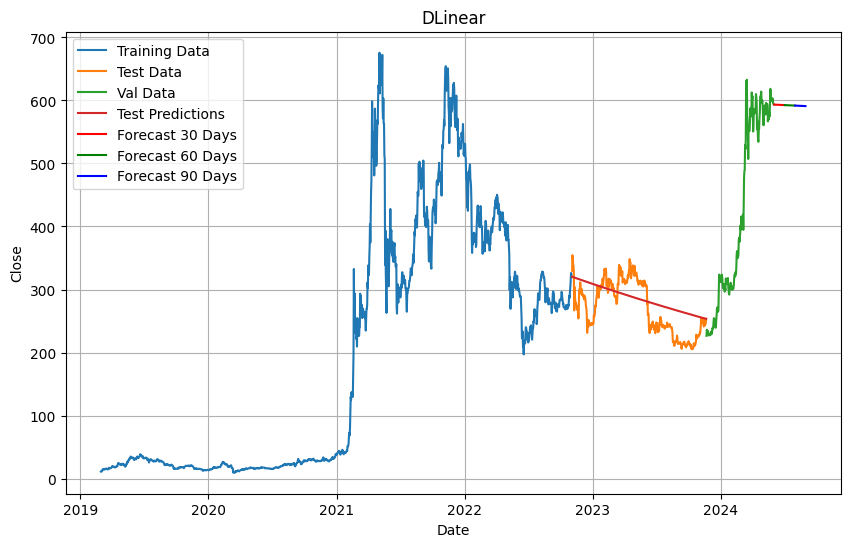

In [33]:
# dl 451 NGÀY
import matplotlib.pyplot as plt
# Chuyển dữ liệu từ Series pandas thành numpy array để vẽ biểu đồ
predicted_values_test = [pred[0].numpy() for pred in predicted_test]
# Chuyển dữ liệu dự báo từ tensor về numpy array
predicted_values = [pred[0].numpy() for pred in predicted]

split_size = len(predicted_values) // 3

predicted_values_30day = predicted_values[:split_size]
predicted_values_60day = predicted_values[split_size:2*split_size]
predicted_values_90day = predicted_values[2*split_size:]
# Tính toán các khoảng thời gian cho mỗi phần
predicted_dates_30day = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=split_size)
predicted_dates_60day = pd.date_range(start=predicted_dates_30day[-1] + pd.DateOffset(days=1), periods=split_size)
predicted_dates_90day = pd.date_range(start=predicted_dates_60day[-1] + pd.DateOffset(days=1), periods=split_size)


# # Chuyển đổi dữ liệu gốc từ tensor về numpy array
# original_values = input_data[0, :, :].numpy()

#
predicted_dates = pd.date_range(start=first_Date + pd.DateOffset(days=1), periods=len(predicted_values))

# Tạo mảng chứa ngày gốc
original_dates = df['Date'].values

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))

plt.plot(train_date_data, train_data, label='Training Data')
plt.plot(test_date_data, test_data, label='Test Data')
plt.plot(val_date_data, val_data, label='Val Data')
plt.plot(test_date_data, predicted_values_test, label='Test Predictions')

plt.plot(predicted_dates_30day, predicted_values_30day, label='Forecast 30 Days', color='red')
plt.plot(predicted_dates_60day, predicted_values_60day, label='Forecast 60 Days', color='green')
plt.plot(predicted_dates_90day, predicted_values_90day, label='Forecast 90 Days', color='blue')


plt.xlabel('Date')
plt.ylabel('Close')
plt.title('DLinear')
plt.legend()
plt.grid(True)
plt.show()

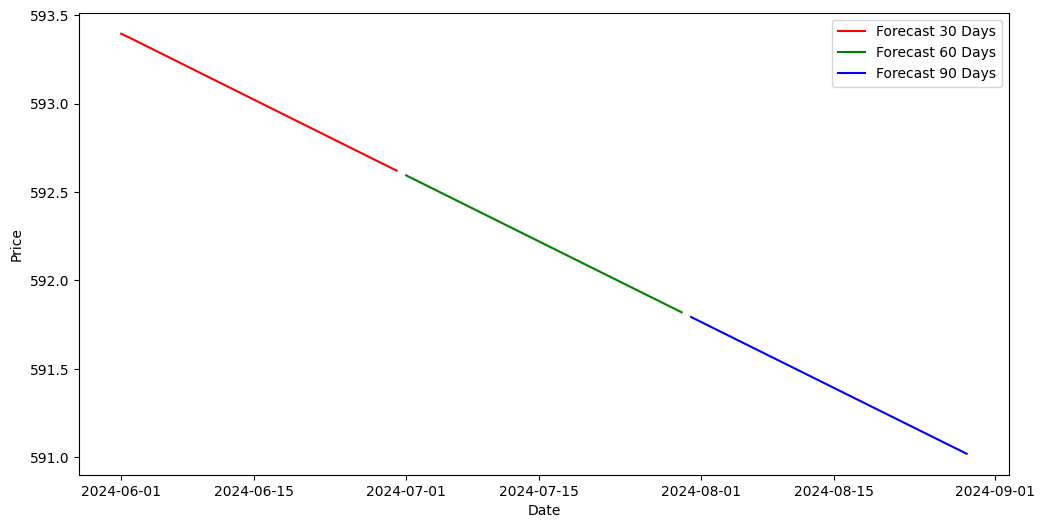

In [34]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(predicted_dates_30day, predicted_values_30day, label='Forecast 30 Days', color='red')
plt.plot(predicted_dates_60day, predicted_values_60day, label='Forecast 60 Days', color='green')
plt.plot(predicted_dates_90day, predicted_values_90day, label='Forecast 90 Days', color='blue')
# plt.title('DLinear - DXG Stock Price - 7:3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# 7. Tính

In [35]:
outputs_test = np.array(predicted_values_test)
outputs_test = outputs_test.flatten()

In [36]:
# Mean Absolute Error (MAE) và Mean Absolute Percentage Error (MAPE)
mae_test = np.mean(np.abs(test_data - outputs_test))
mape_test = np.mean(np.abs((test_data - outputs_test) / test_data)) * 100
rmse_test = np.sqrt(np.mean((test_data - outputs_test) ** 2))

print("MAE:", mae_test)
print("MAPE:", mape_test)
print("RMSE:", rmse_test)

MAE: 31.824963044248737
MAPE: 12.592045129207657
RMSE: 35.98443865722963
